# Proyecto 2 Reconocimiento de Patrones

José Julián Camacho Hernández

Leonardo Guillén Fernández

In [1]:
import os
import cv2
import time
import math
import torch
import numpy as np
import pandas as pd
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from IPython.display import display
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, auc, roc_auc_score, roc_curve, f1_score

# MLP

In [2]:
def computeMetrics(y_test, y_pred, training_time):
    acc = accuracy_score(y_test, y_pred)                        # Calcular la exactitud
    f1 = f1_score(y_test, y_pred, average='macro')              # Calcular F1 score
    rec = recall_score(y_test, y_pred, average='macro')         # Calcular el recall
    prec = precision_score(y_test, y_pred, average='macro')     # Calcular la precisión
    #auc = roc_auc_score(y_test, y_pred, average='macro')        # Calcular AUC , "AUC":auc}
    
    true_labels_binary = label_binarize(y_test, classes=[0,1,2,3])
    auc_ = roc_auc_score(true_labels_binary, y_pred.reshape(-1, 1), average='macro')
    
    n_classes = 4
    print(y_test)
    print(y_pred.shape)
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
    y_pred_bin = np.zeros((len(y_test), n_classes))
    y_pred_bin[np.arange(len(y_test)), y_pred] = 1    
    print(y_pred_bin)
    metrics = {"Accuracy":acc, "Precision":prec, "Recall":rec, "F1 Score":f1, "AUC":auc_, "Tiempo de entrenamiento":training_time}
    df = pd.DataFrame(metrics, index = [0])
    display(df)

    # Calcular la curva ROC

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.figure()

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='Class {} (AUC = {:.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()


## MLP sin feature extractor

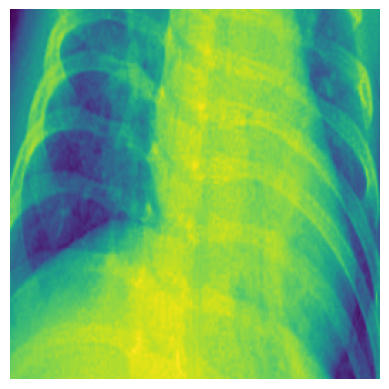

In [86]:
#=====  Cargar y aplicar feature extractor a las imágenes  =====#
X = []
y = []

input_folders = ["./testi3/", "./testi4/", "./testi2/", "./testi/"]
#input_folders = ["./COVID-19_Radiography_Dataset/COVID/", "./COVID-19_Radiography_Dataset/Lung_Opacity/",
#                 "./COVID-19_Radiography_Dataset/Normal/", "./COVID-19_Radiography_Dataset/Viral_Pneumonia/"]
#input_folders = ["drive/MyDrive/COVID-19_Radiography_Dataset/COVID/", "drive/MyDrive/COVID-19_Radiography_Dataset/Lung_Opacity/",
#                 "drive/MyDrive/COVID-19_Radiography_Dataset/Normal/", "drive/MyDrive/COVID-19_Radiography_Dataset/Viral_Pneumonia/"]

i = 0
for folder in input_folders:
    input_folder = folder
    for filename in os.listdir(input_folder):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            #image_path = os.path.join(input_folder, filename)
            image = Image.open(image_path)
            image = image.crop((20, 20, 280, 280))
            image = image.convert('L')          # Convertir a escala de grises
            #image = np.array(image).flatten()   # Flatten the image

            #image_path = os.path.join(input_folder, filename)
            #image = cv2.imread(image_path)

            X.append(image)
            y.append(i)
    i+=1

pil_image_arr = np.array(X[0])
plt.imshow(pil_image_arr)
plt.axis('off')
pil_image.show()
#np.save("X.npy", X)
#np.save("y.npy", y)
#np.save("drive/MyDrive/X.npy", X)
#np.save("drive/MyDrive/y.npy", y)

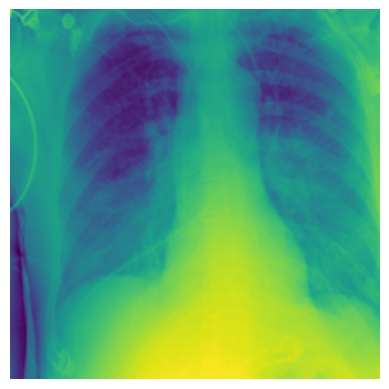

In [79]:
#=====  Feature Engineering  =====#

try:
    X_charged = np.load("X.npy")
    y_charged = np.load("y.npy")
    #X_charged = np.load("drive/MyDrive/X.npy")
    #y_charged = np.load("drive/MyDrive/y.npy")
except FileNotFoundError:
    print("Error: File not found.")
       
# Convertir las listas a numpy array de tipo uint8
X_np = np.array(X_charged, dtype=np.uint8)
y_np = np.array(y_charged)

# Dividir los datos en train y test y estratificar
train_X, test_X, train_y, test_y = train_test_split(
    X_np, y_np, test_size=0.2, stratify=y_np, random_state=42)

# Normalización de los datos
scaler = MinMaxScaler()
scaler.fit(train_X)
scaled_data = scaler.transform(train_X)
train_X = scaled_data

# Convertir de numpy array a PyTorch tensor
X_train_tensor = torch.from_numpy(train_X).float()
X_test_tensor = torch.from_numpy(test_X).float()
y_train_tensor = torch.from_numpy(train_y).float()
y_test_tensor = torch.from_numpy(test_y).float()

# Convertir a tensores de tipo long
y_train_long_tensor = y_train_tensor.long()         

# Convertir a one hot
y_onehot = F.one_hot(y_train_long_tensor, num_classes=4).float()


In [4]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes, activation):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.hidden_layers = nn.ModuleList()
        self.num_classes = num_classes
        self.activation = activation
        # Agregar capas ocultas
        for i, hidden_size in enumerate(hidden_sizes):
            if i == 0:
                self.hidden_layers.append(nn.Linear(input_size, hidden_size))
            else:
                self.hidden_layers.append(nn.Linear(hidden_sizes[i-1], hidden_size))
        # Capa de salida
        self.output_layer = nn.Linear(hidden_sizes[-1], num_classes)
        
    def forward(self, x):
        out = x
        # Pasar por capas ocultas
        for layer in self.hidden_layers:
            out = layer(out)
            out = self.activation(out)
        # Pasar por capa de salida
        out = self.output_layer(out)
        return out

### Diseño # 1
Capas: [81401, 128, 64, 4] | Función de activación: ReLU | α = 0.001 | epochs = 1000

67600


/home/jose/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


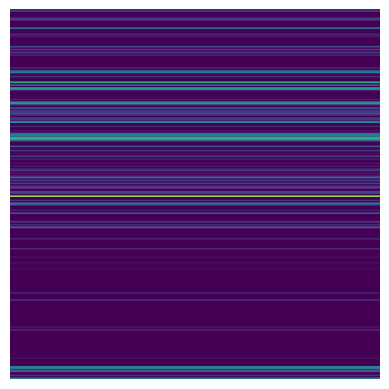

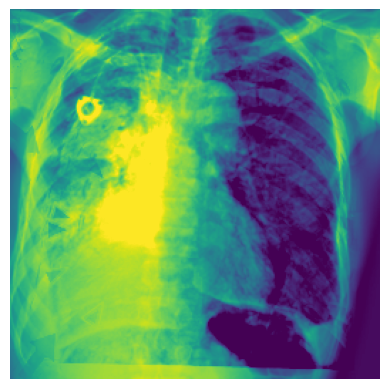

In [89]:
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import cv2

# Prepare the pre-trained MLP model
input_size = X_train_tensor.shape[1]
print(input_size)
hidden_sizes = [64]
num_classes = 4
activation = F.relu
model = MLP(input_size, hidden_sizes, num_classes, activation)

# Define the loss function, learning rate, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

start_time = time.time()
# Train the model
for epoch in range(10):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_onehot)
    loss.backward()
    optimizer.step()
end_time = time.time()
time_taken = end_time - start_time

# Save the model weights
torch.save(model.state_dict(), 'path_to_model_weights.pth')

# Evaluate the model
outputs = model(X_test_tensor)
_, predicted = torch.max(outputs.data, 1)

# Load the pre-trained model and specify the target layer for Grad-CAM
model = MLP(input_size, hidden_sizes, num_classes, activation)
model.load_state_dict(torch.load('path_to_model_weights.pth'))
target_layer = model.hidden_layers[-1]  # Choose the last hidden layer for visualization

# Preprocess the image
#image_path = './COVID-19_Radiography_Dataset/COVID/COVID-1.png'
#image = Image.open(image_path).convert('RGB')
#preprocess = transforms.Compose([
#    transforms.Resize((260, 260)),
#    transforms.ToTensor(),
#    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#])
#input_image = preprocess(image).unsqueeze(0)

# Choose an image from the training set
image_index = 10  # Index of the image in the training set
image= X_train_tensor[image_index]

# Preprocess the image
input_image = image.unsqueeze(0)

# Set the model to evaluation mode
model.eval()

# Forward pass and backward hook
def backward_hook(module, grad_input, grad_output):
    # Save the gradients during the backward pass
    global saved_gradients
    saved_gradients = grad_input[0]

target_layer.register_backward_hook(backward_hook)

# Forward pass
output = model(input_image)
predicted_class = torch.argmax(output, dim=1).item()

# Calculate the gradients
model.zero_grad()
one_hot = torch.zeros_like(outputs)
one_hot.scatter_(1, predicted.view(-1, 1), 1.0)
outputs.backward(gradient=one_hot)

# Generate the saliency map
gradients = saved_gradients.squeeze()
weighted_feature_maps = torch.zeros_like(target_layer.weight.data)
for i in range(target_layer.weight.shape[0]):
    weighted_feature_maps[i] = target_layer.weight.data[i] * gradients[i]

saliency_map = weighted_feature_maps.sum(dim=0)
saliency_map = F.relu(saliency_map)

# Resize the saliency map
saliency_map = saliency_map.detach().cpu().numpy()
saliency_map = cv2.resize(saliency_map, (260, 260))

# Convert the saliency map to PIL image
saliency_map_pil = Image.fromarray(saliency_map)
# Convert the overlay image to a numpy array
overlay_array = np.array(saliency_map_pil)

# Display the overlay image
plt.imshow(overlay_array)
plt.axis('off')
plt.show()

# Reshape the tensor to match the desired image size
reshaped_tensor = image.view(260, 260)
# Convert the reshaped tensor to a NumPy array
numpy_array = reshaped_tensor.detach().cpu().numpy()
# Convert the NumPy array to a PIL image
pil_image = Image.fromarray(numpy_array)
# You can now use the PIL image as needed
pil_image_arr = np.array(pil_image)
# For example, display the image
plt.imshow(pil_image_arr)
plt.axis('off')
pil_image.show()

# Resize the original image to match the saliency map size
#resized_image = input_image.resize(260, 260)

# Overlay the saliency map on the resized original image
#overlay_image = Image.blend(resized_image.convert('RGBA'), saliency_map_pil.convert('RGBA'), alpha=0.5)

# Display the overlay image
#plt.imshow(overlay_image)
#plt.axis('off')
#plt.show()

### Diseño # 2
Capas: [81401, 256, 128, 64, 4] | Función de activación: ReLU | α = 0.001 | epochs = 1000

tensor([1., 0., 0., 3., 2., 2., 0., 2., 0., 1., 3., 0., 2., 3., 1., 1., 3., 2.,
        2., 3., 0., 0., 1., 3., 0., 2., 2.])
torch.Size([27])
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


,Accuracy,Precision,Recall,F1 Score,AUC,Tiempo de entrenamiento
0,0.518519,0.631944,0.4875,0.466346,0.263158,99.905563


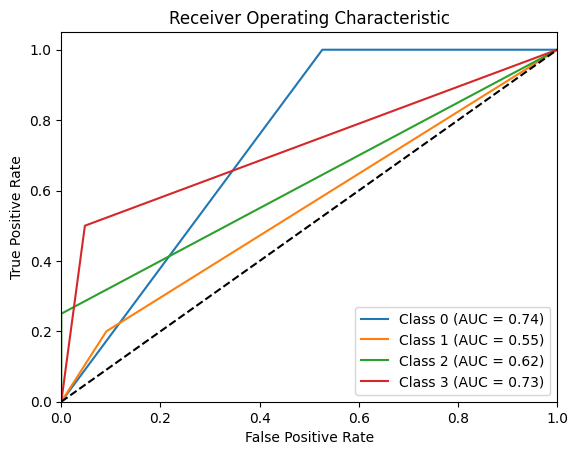

Resultados esperados:  tensor([1., 0., 0., 3., 2., 2., 0., 2., 0., 1., 3., 0., 2., 3., 1., 1., 3., 2.,
        2., 3., 0., 0., 1., 3., 0., 2., 2.])
Resultados obtenidos:  tensor([0, 0, 0, 3, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 3, 1, 3, 0, 1, 3, 0, 0, 0, 0,
        0, 0, 0])


In [34]:
#=====  Instaciar modelo  =====#

input_size = X_train_tensor.shape[1]
hidden_sizes = [256, 128, 64]       
num_classes = 4   
activation = F.relu
model = MLP(input_size, hidden_sizes, num_classes, activation)   

# Definir la función de loss con learning rate y optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

start_time = time.time()
# Entrenar el modelo
for epoch in range(500):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_onehot)
    loss.backward()
    optimizer.step()
end_time = time.time()
time_taken = end_time - start_time

# Evaluate the model
outputs = model(X_test_tensor)
_, predicted = torch.max(outputs.data, 1)

# Obtener métricas
computeMetrics(y_test_tensor, predicted, time_taken)
print('Resultados esperados: ', y_test_tensor)
print('Resultados obtenidos: ', predicted)


### Diseño # 3
Capas: [81401, 128, 64, 4] | Función de activación: ReLU | α = 0.001 | epochs = 1000

In [130]:
#=====  Instaciar modelo  =====#

input_size = X_train_tensor.shape[1]
hidden_sizes = [150, 50]       
num_classes = len(set(y_train_tensor))   
activation = F.relu
model = MLP(input_size, hidden_sizes, num_classes, activation)   

# Definir la función de loss con learning rate y optimizer
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

start_time = time.time()
# Entrenar el modelo
for epoch in range(1000):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_onehot)
    loss.backward()
    optimizer.step()
end_time = time.time()
time_taken = end_time - start_time

# Evaluate the model
outputs = model(X_test_tensor)
_, predicted = torch.max(outputs.data, 1)

# Obtener métricas
computeMetrics(y_test_tensor, predicted, time_taken)
print('Resultados esperados: ', y_test_tensor)
print('Resultados obtenidos: ', predicted)


,Accuracy,Precision,Recall,F1 Score,AUC,Tiempo de entrenamiento
0,0.703704,0.754167,0.691667,0.703571,0.161184,151.206025


Resultados esperados:  tensor([1., 0., 0., 3., 2., 2., 0., 2., 0., 1., 3., 0., 2., 3., 1., 1., 3., 2.,
        2., 3., 0., 0., 1., 3., 0., 2., 2.])
Resultados obtenidos:  tensor([0, 1, 0, 3, 2, 2, 0, 2, 0, 1, 2, 0, 0, 0, 1, 1, 3, 0, 1, 3, 0, 0, 0, 3,
        0, 2, 2])


In [124]:
#=====  Instaciar modelo  =====#

input_size = X_train_tensor.shape[1]
hidden_sizes = [200, 50]       
num_classes = len(set(y_train_tensor))   
activation = F.relu
model = MLP(input_size, hidden_sizes, num_classes, activation)   

# Definir la función de loss con learning rate y optimizer
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

start_time = time.time()
# Entrenar el modelo
for epoch in range(20):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_onehot)
    loss.backward()
    optimizer.step()
end_time = time.time()
time_taken = end_time - start_time

# Evaluate the model
outputs = model(X_test_tensor)
_, predicted = torch.max(outputs.data, 1)

# Obtener métricas
computeMetrics(y_test_tensor, predicted, time_taken)
print('Resultados esperados: ', y_test_tensor)
print('Resultados obtenidos: ', predicted)


,Accuracy,Precision,Recall,F1 Score,AUC,Tiempo de entrenamiento
0,0.62963,0.695513,0.63125,0.557143,0.131579,4.094419


IndexError: too many indices for tensor of dimension 1

## MLP con feature extractor LBP

In [7]:
#=====  Feature Extractor  =====#
def lbp(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp_image = np.zeros_like(gray)
    for i in range(1, gray.shape[0] - 1):
        for j in range(1, gray.shape[1] - 1):
            binary = ""
            center = gray[i, j]
            for x, y in [(-1, -1), (-1, 0), (-1, 1), (0, 1), (1, 1), (1, 0), (1, -1), (0, -1)]:
                if gray[i + x, j + y] >= center:
                    binary += "1"
                else:
                    binary += "0"
            lbp_image[i, j] = int(binary, 2)
    return lbp_image.flatten()

In [16]:
#=====  Cargar y aplicar feature extractor a las imágenes  =====#
lbp_arrays = []
lbp_labels = []

input_folders = ["./testi3/", "./testi4/", "./testi2/", "./testi/"]
#input_folders = ["./COVID-19_Radiography_Dataset/COVID/", "./COVID-19_Radiography_Dataset/Lung_Opacity/",
#                 "./COVID-19_Radiography_Dataset/Normal/", "./COVID-19_Radiography_Dataset/Viral_Pneumonia/"]
i = 0
for folder in input_folders:
    input_folder = folder
    for filename in os.listdir(input_folder):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(input_folder, filename)
            image = cv2.imread(image_path)
            lbp_array = lbp(image)
            lbp_arrays.append(lbp_array)
            lbp_labels.append(i)
    i+=1

np.save("lbp_arrays.npy", lbp_arrays)
np.save("lbp_labels.npy", lbp_labels)

In [5]:
#=====  Feature Engineering  =====#

try:
    lbp_arrays_charged = np.load("./arrays/lbp_arrays.npy")
    labels_charged = np.load("./arrays/lbp_labels.npy")
except FileNotFoundError:
    print("Error: File not found.")
    
print(lbp_arrays_charged)    
print(labels_charged)    
# Convertir las listas a numpy array de tipo uint8
lbp_np_arrays = np.array(lbp_arrays_charged, dtype=np.uint8)
labels_np = np.array(labels_charged)

# Dividir los datos en train y test y estratificar
train_lbp, test_lbp, train_labels, test_labels = train_test_split(
    lbp_np_arrays, labels_np, test_size=0.2, stratify=labels_np, random_state=42)

# Normalización de los datos
scaler = MinMaxScaler()
scaler.fit(train_lbp)
scaled_data = scaler.transform(train_lbp)
train_lbp = scaled_data

# Convertir de numpy array a PyTorch tensor
lbp_train_tensor = torch.from_numpy(train_lbp).float()
lbp_test_tensor = torch.from_numpy(test_lbp).float()
labels_train_tensor = torch.from_numpy(train_labels).float()
labels_test_tensor = torch.from_numpy(test_labels).float()


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[0 0 0 ... 3 3 3]


In [29]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [30]:
# Instaciar modelo
input_size = lbp_train_tensor.shape[1]
hidden_size = 64
output_size = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(input_size, hidden_size, output_size)

# Definir la función de loss y optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

start_time = time.time()
# Entrenar el modelo
for epoch in range(1000):
    optimizer.zero_grad()
    outputs = model(lbp_train_tensor)

    labels_train_long_tensor = labels_train_tensor.long()         
    labels_train_long_tensor = labels_train_long_tensor.to(device)
    labels_onehot = F.one_hot(labels_train_long_tensor, num_classes=output_size).float()

    loss = criterion(outputs, labels_onehot)
    loss.backward()
    optimizer.step()
end_time = time.time()
time_taken = end_time - start_time

# Evaluate the model
outputs = model(lbp_test_tensor)
_, predicted = torch.max(outputs.data, 1)

# Obtener métricas
computeMetrics(y_test_tensor, predicted, time_taken)
print('Resultados esperados: ', labels_test_tensor)
print('Resultados obtenidos: ', predicted)

,Accuracy,Precision,Recall,F1 Score,Tiempo de entrenamiento
0,0.777778,0.75625,0.783333,0.73953,67.009742


Resultados esperados:  tensor([1., 0., 0., 3., 2., 2., 0., 2., 0., 1., 3., 0., 2., 3., 1., 1., 3., 2.,
        2., 3., 0., 0., 1., 3., 0., 2., 2.])
Resultados obtenidos:  tensor([0, 0, 0, 3, 2, 2, 0, 2, 0, 1, 3, 0, 3, 3, 1, 3, 3, 2, 1, 3, 0, 0, 0, 3,
        0, 3, 2])


# CNN

In [63]:
import cv2

# Load the image
image_path = os.path.join('./COVID-19_Radiography_Dataset/COVID/', 'COVID-2.png')
image = Image.open(image_path)
image = image.crop((20, 20, 280, 280))

# Display the cropped image
image.save('path_to_cropped_image.jpg')

In [70]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Define your MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes, activation):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.hidden_layers = nn.ModuleList()
        self.num_classes = num_classes
        self.activation = activation
        # Add hidden layers
        for i, hidden_size in enumerate(hidden_sizes):
            if i == 0:
                self.hidden_layers.append(nn.Linear(input_size, hidden_size))
            else:
                self.hidden_layers.append(nn.Linear(hidden_sizes[i-1], hidden_size))
        # Output layer
        self.output_layer = nn.Linear(hidden_sizes[-1], num_classes)
        
    def forward(self, x):
        out = x
        # Pass through hidden layers
        for layer in self.hidden_layers:
            out = layer(out)
            out = self.activation(out)
        # Pass through the output layer
        out = self.output_layer(out)
        return out

# Instantiate the model
input_size = X_train_tensor.shape[1]
hidden_sizes = [64]
num_classes = 4
activation = F.relu
model = MLP(input_size, hidden_sizes, num_classes, activation)

torch.save(model.state_dict(), 'mlp_model.pth')
# Load the trained model weights
model.load_state_dict(torch.load('mlp_model.pth'))

# Set the model to evaluation mode
model.eval()


X_f = X_train_tensor[0]  
# Convertir las listas a numpy array de tipo uint8
input_image = np.array(X_f, dtype=np.uint8)
print(X_f)  
#input_data = torch.from_numpy(input_image).float()

# Prepare the input data and wrap it in a Variable with requires_grad=True
input_data = torch.from_numpy(np.transpose(input_image, (2, 0, 1))).float()
input_data = Variable(input_data.unsqueeze(0), requires_grad=True)

# Forward pass the input through the model
output = model(input_data)

# Perform the backward pass
output.backward()

# Compute the saliency map by taking the absolute values of the gradients and summing across the input channels
saliency_map = torch.abs(input_data.grad).sum(dim=1, keepdim=True)

# Normalize the saliency map for visualization
saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())

# Resize the saliency map to match the input image size
saliency_map = cv2.resize(saliency_map[0, 0].detach().numpy(), (input_image.shape[1], input_image.shape[0]))

# Overlay the saliency map on the input image
heatmap = cv2.applyColorMap((saliency_map * 255).astype(np.uint8), cv2.COLORMAP_JET)
result = cv2.addWeighted(input_image, 0.7, heatmap, 0.3, 0)

# Display the input image and saliency map side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(input_image)
ax[0].set_title('Input Image')
ax[0].axis('off')
ax[1].imshow(result)
ax[1].set_title('Saliency Map')
ax[1].axis('off')
plt.show()



tensor([0.1207, 0.1667, 0.2257,  ..., 0.4055, 0.2520, 0.1969])


ValueError: axes don't match array